<a href="https://colab.research.google.com/github/jon-chun/GenAI-Multi-Agent-Networks-and-Digital-Twins/blob/main/code/notebooks/sentimentarcs_supersimplified_20241114.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>


# SentimentArcs Simplified Notebook

## ***Use GPU for Transformer Models***

* 28 Oct 2022: Created
* 12 Nov 2024: Last Major Update
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

In [1]:
%whos

# CHECK program space for imported and defined objects

Interactive namespace is empty.


# **PRE-REQUISITES**

## INPUT Text File
- name: format 'book_{title-words}_{author}.txt'
-- eg book_animal-farm_gorwell.txt
-- eg book_the-great-gatsby_fscottfitzgerald.txt
- content: cleaned plain text

## API Keys Necessary
- huggingface.co ('HF_TOKEN')
- wandb.com ('WANDB_TOKEN')



# Setup

## Install Libraries

In [2]:
# !pip install transformers[sentencepiece]

!pip install transformers

In [3]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [4]:
from google.colab import files

In [5]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks, argrelextrema
from statsmodels.nonparametric.smoothers_lowess import lowess
import textwrap

import datetime
import re
import os

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

## Configure Settings

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [7]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [8]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [9]:
def save_text2txt_and_download(text_obj, filename_base='BOOK_FILENAME_BASE', file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  # out_filename = novel_name_str.split('.')[0] + file_suffix
  out_filename = filename_base + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [10]:
def save_plot2png(file_suffix='_plot.png', nodate=True, base_filename='plot'):
    '''
    Save the current plot to a PNG file.

    INPUT:
    - file_suffix: The suffix to add to the output PNG filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "plot" if unspecified).

    OUTPUT:
    - Saves the current plot to a PNG file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the plot
    plt.savefig(out_filename)
    print(f'STEP 1. Saving plot to temporary VM file: {out_filename}\n')

    # Download the saved file
    print(f'STEP 2. Downloading permanent copy of the PNG file: {out_filename}\n')
    files.download(out_filename)

In [11]:
def save_df2csv_and_download(df, file_suffix='_data.csv', nodate=True, base_filename='data'):
    '''
    Save the DataFrame to a CSV file.

    INPUT:
    - df: The DataFrame to save.
    - file_suffix: The suffix to add to the output CSV filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.
    - base_filename: The base filename to use (defaults to "data" if unspecified).

    OUTPUT:
    - Saves the DataFrame to a CSV file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = base_filename + file_suffix
    else:
        out_filename = base_filename + '_' + datetime_str + file_suffix

    # Save the DataFrame to CSV
    df.to_csv(out_filename, index=False)
    print(f'STEP 1. Saving DataFrame to temporary VM CSV file: {out_filename}\n')

    # Download the saved CSV file
    print(f'STEP 2. Downloading permanent copy of the CSV file: {out_filename}\n')
    files.download(out_filename)

# Get Clean Text

## **[STOP to INPUT]** Upload Trimmed Gutenberg Text (no header/footer)

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [12]:
# PART 1: Upload Plain Text File

novel_name_str = ''
uploaded = files.upload()

# Allows for multiple file uploads, will only process the last
# Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    novel_name_str = fn

# Extract from Dict and decode binary into char string
TEXT_ENCODING = 'utf-8'  # Define the encoding format
novel_raw_str = uploaded[novel_name_str].decode(TEXT_ENCODING)

# BOOK_FILENAME_AUTHOR = novel_name_str.split('.')[0]
# BOOK_FILENAME_AUTHOR

Saving book_dracula_bramstoker.txt to book_dracula_bramstoker.txt
User uploaded file "book_dracula_bramstoker.txt" with length 866625 bytes


In [13]:
# PART 2: Verify Upload Text

verify_novel(novel_raw_str)

Novel Name: book_dracula_bramstoker.txt
  Char Len: 857503

Beginning:

 
DRACULA




CHAPTER I

JONATHAN HARKER’S JOURNAL

(_Kept in shorthand._)


_3 May. Bistritz._--Left Munich at 8:35 P. M., on 1st May, arriving at
Vienna early next morning; should have arrived at 6:46, but train was an
hour late. Buda-Pesth seems a wonderful place, from the glimpse which I
got of it from the train and the little I could walk through the
streets. I feared to go very far from the station, as we had arrived
late and would start as near the correct time as possibl



------------------------------------
Ending:

 randum.
We could hardly ask any one, even did we wish to, to accept these as
proofs of so wild a story. Van Helsing summed it all up as he said, with
our boy on his knee:--

“We want no proofs; we ask none to believe us! This boy will some day
know what a brave and gallant woman his mother is. Already he knows her
sweetness and loving care; later on he will understand how some men so
loved h

In [16]:
# PART 3: Verify FILENAME variants based upon uploaded filename

BOOK_FILENAME_AUTHOR_CLEAN = novel_name_str.split('.')[0]
print(f"BOOK_FILENAME_AUTHOR_CLEAN: {BOOK_FILENAME_AUTHOR_CLEAN}")

print('\n')

# prompt: set book_filename_author_clean = a cleaned version of BOOK_FILENAME_AUTHOR that is 1. lowercased, 2. spaces replaced with '_' and 3. all punctuation except for dashes and underlines replaced with '-'
BOOK_TITLE_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.lower().replace(' ', '_').replace('[^a-zA-Z0-9_-]', '-')
print(f"BOOK_TITLE_AUTHOR_CLEAN: {BOOK_TITLE_AUTHOR_CLEAN}")

print('\n')

# prompt: set BOOK_TITLE_AUTHOR_TITLE = BOOK_TITLE_AUTHOR_CLEAN with '_' replaced by ' ' and the first letter of all words Capitalized
BOOK_TITLE_AUTHOR_TITLE = BOOK_TITLE_AUTHOR_CLEAN.replace('_', ' ').title()
print(f"BOOK_TITLE_AUTHOR_TITLE: {BOOK_TITLE_AUTHOR_TITLE}")

print('\n')

# prompt: change the leading string 'book_' with 'plot_' in the var BOOK_TITLE_AUTHOR_CLEAN

PLOT_FILENAME_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.replace('book_', 'plot_')
print(f"PLOT_FILENAME_AUTHOR_CLEAN: {PLOT_FILENAME_AUTHOR_CLEAN}")

print('\n')

# prompt: change the leading string 'book_' with 'data_' in the var BOOK_TITLE_AUTHOR_CLEAN

DATA_FILENAME_AUTHOR_CLEAN = BOOK_FILENAME_AUTHOR_CLEAN.replace('book_', 'data_')
print(f"DATA_FILENAME_AUTHOR_CLEAN: {DATA_FILENAME_AUTHOR_CLEAN}")

BOOK_FILENAME_AUTHOR_CLEAN: book_dracula_bramstoker


BOOK_TITLE_AUTHOR_CLEAN: book_dracula_bramstoker


BOOK_TITLE_AUTHOR_TITLE: Book Dracula Bramstoker


PLOT_FILENAME_AUTHOR_CLEAN: plot_dracula_bramstoker


DATA_FILENAME_AUTHOR_CLEAN: data_dracula_bramstoker


## Clean Text

In [17]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=c86e198041f5502820b553eb6e25f1ef4a91199cb9c2dd7ae5700921cc9a7421
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [18]:
!pip install unidecode  # clean-text dependency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.9 MB/s eta 0:00:00


In [19]:
from cleantext import clean

In [20]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'dracula chapter i jonathan harker\'s journal (_kept in shorthand._) _3 may. bistritz._--left munich at 8:35 p. m., on 1st may, arriving at vienna early next morning; should have arrived at 6:46, but train was an hour late. buda-pesth seems a wonderful place, from the glimpse which i got of it from the train and the little i could walk through the streets. i feared to go very far from the station, as we had arrived late and would start as near the correct time as possible. the impression i had was that we were leaving the west and entering the east; the most western of splendid bridges over the danube, which is here of noble width and depth, took us among the traditions of turkish rule. we left in pretty good time, and came after nightfall to klausenburgh. here i stopped for the night at the hotel royale. i had for dinner, or rather supper, a chicken done up some way with red pepper, which was very good but thirsty. (_mem._, get recipe for mina.) i asked the waiter, and he said it was 

In [21]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: book_dracula_bramstoker.txt
  Char Len: 835258

Beginning:

 dracula chapter i jonathan harker's journal (_kept in shorthand._) _3 may. bistritz._--left munich at 8:35 p. m., on 1st may, arriving at vienna early next morning; should have arrived at 6:46, but train was an hour late. buda-pesth seems a wonderful place, from the glimpse which i got of it from the train and the little i could walk through the streets. i feared to go very far from the station, as we had arrived late and would start as near the correct time as possible. the impression i had was



------------------------------------
Ending:

 na and seward and myself, and van helsing's memorandum. we could hardly ask any one, even did we wish to, to accept these as proofs of so wild a story. van helsing summed it all up as he said, with our boy on his knee:-- "we want no proofs; we ask none to believe us! this boy will some day know what a brave and gallant woman his mother is. already he knows her sweetness and

## Trim Text

In [22]:
# FUTURE: Auto trim Gutenberg HEADER and FOOTER (varies too much)

novel_trim_str = novel_clean_str

## Segment Text

In [23]:
!pip install pysbd  # Python Sentence Boundry Detection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.8 MB/s eta 0:00:00


In [24]:
import pysbd

In [25]:
# FUTURE: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [26]:
'''

# FUTURE: Display Segmenting Progress Bar

from IPython.display import clear_output
import pysbd
import time  # Only for simulating delay in testing

# Set up the segmenter
seg = pysbd.Segmenter(language="en", clean=False)

# Segment novel with manual progress feedback
novel_segments_ls = []
total_segments = len(novel_trim_str.split('.'))  # Estimate segment count based on periods
update_every_n = 100  # Update output every 100 segments

# Start segmentation and manual progress display
for idx, segment in enumerate(seg.segment(novel_trim_str), start=1):
    novel_segments_ls.append(segment)

    # Periodically update the output
    if idx % update_every_n == 0 or idx == total_segments:
        clear_output(wait=True)
        print(f"Segmenting Novel: {idx}/{total_segments} segments processed")

print("Segmentation complete.")
''';

In [28]:
%%time

# NOTE:  1m05s animal farm
#       11m22s harry potter
#        2m13s jane eyre
#        2m38s dracula

# Split Novel into Segments (~Sentences)
seg = pysbd.Segmenter(language="en", clean=False)
# novel_segments_ls = seg.segment(novel_trim_str)
novel_segments_ls = [segment for segment in tqdm(seg.segment(novel_trim_str), desc="Segmenting Novel")]

Segmenting Novel: 100%|██████████| 3181/3181 [00:00<00:00, 2605366.34it/s]

CPU times: user 2min 3s, sys: 334 ms, total: 2min 3s
Wall time: 2min 38s


In [29]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [30]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: book_dracula_bramstoker.txt
  Char Len: 3181

Beginning:

 ["dracula chapter i jonathan harker's journal (_kept in shorthand._) _3 may. bistritz._--left munich at 8:35 p.", 'm.', ', on 1st may, arriving at vienna early next morning; should have arrived at 6:46, but train was an hour late.', 'buda-pesth seems a wonderful place, from the glimpse which i got of it from the train and the little i could walk through the streets.', 'i feared to go very far from the station, as we had arrived late and would start as near the correct time as possible.', 'the impression i had was that we were leaving the west and entering the east; the most western of splendid bridges over the danube, which is here of noble width and depth, took us among the traditions of turkish rule.', 'we left in pretty good time, and came after nightfall to klausenburgh.', 'here i stopped for the night at the hotel royale.', 'i had for dinner, or rather supper, a chicken done up some way with red pepper, which w

In [31]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, BOOK_TITLE_AUTHOR_CLEAN, '_segments.txt')

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: book_dracula_bramstoker_segments.txt

STEP 3. Downloading permanent copy of textfile: book_dracula_bramstoker_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

3180

,line_no,line
0,0,dracula chapter i jonathan harker's journal (_...
1,1,m.
2,2,", on 1st may, arriving at vienna early next mo..."
3,3,"buda-pesth seems a wonderful place, from the g..."
4,4,"i feared to go very far from the station, as w..."


# Compute Sentiment

## STEP (1): Symbolic: Lexicons

### VADER

In [33]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [35]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [36]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['vader'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,vader
0,0,dracula chapter i jonathan harker's journal (_...,0.0000
1,1,m.,0.0000
2,2,", on 1st may, arriving at vienna early next mo...",0.0000
3,3,"buda-pesth seems a wonderful place, from the g...",0.5719
4,4,"i feared to go very far from the station, as w...",-0.4939


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Dracula Bramstoker\nVADER Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_dracula_bramstoker_vader_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_dracula_bramstoker_vader_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

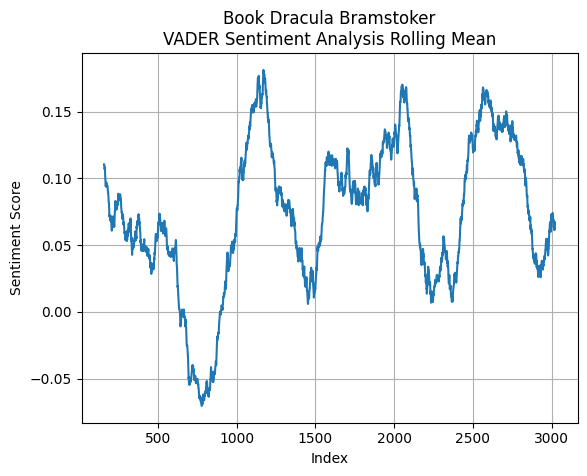

In [37]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = vader_df['vader'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nVADER Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_vader')

plt.show()

# Close the plot to free up memory
plt.close()

In [38]:
# Call the function to save the DataFrame to CSV
save_df2csv_and_download(vader_df, '_vader_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)

STEP 1. Saving DataFrame to temporary VM CSV file: data_dracula_bramstoker_vader_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_dracula_bramstoker_vader_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TextBlob

In [39]:
from textblob import TextBlob

In [40]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [41]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [42]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['textblob'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,textblob
0,0,dracula chapter i jonathan harker's journal (_...,0.000000
1,1,m.,0.000000
2,2,", on 1st may, arriving at vienna early next mo...",-0.066667
3,3,"buda-pesth seems a wonderful place, from the g...",0.406250
4,4,"i feared to go very far from the station, as w...",-0.017500


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Dracula Bramstoker\nTextBlob Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_dracula_bramstoker_textblob_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_dracula_bramstoker_textblob_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

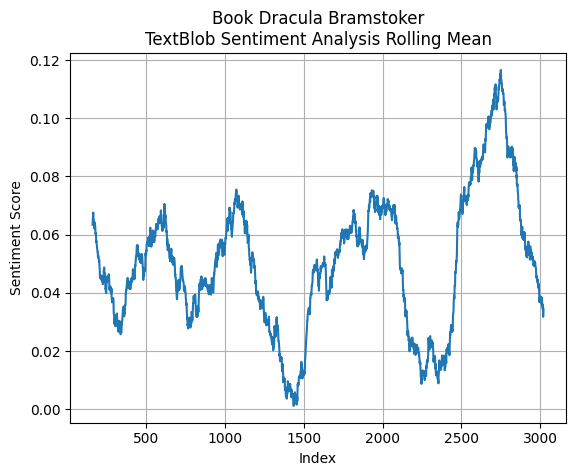

In [43]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'sentiment' column
_ = textblob_df['textblob'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nTextBlob Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_textblob')

plt.show()

# Close the plot to free up memory
plt.close()


In [44]:
###CODE_5:
# Save TextBlob Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(textblob_df, '_textblob_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)

STEP 1. Saving DataFrame to temporary VM CSV file: data_dracula_bramstoker_textblob_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_dracula_bramstoker_textblob_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## STEP (2): Connectionist: Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

In [45]:
!pip install -q transformers

In [46]:
!pip install sentencepiece

In [47]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

In [48]:
from transformers import TrainingArguments

In [49]:
# Test Dataset: List of TestSentiment Strings

test_lines_ls = [
    "I love you.",
    "You hate me.",
    "I'm not sure if I hate you, but I certainly don't care for your attitude young man!"
]

In [50]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### HF: DistilBERT Finetuned (sst2en)

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

In [51]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [52]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [53]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [54]:
# import wandb

# wandb.init() # wandb.log()

In [55]:
%%time

# NOTE: Must click on output LINK, get wandb API_KEY, and paste it in text input box

# NOTE: 0m40s 02:49EST on 28Oct2022 Colab Pro (The Idiot)


# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 36.3 s, sys: 420 ms, total: 36.7 s
Wall time: 51.4 s


In [56]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [57]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [58]:
line_no_ls = list(range(len(sentiment_ls)))

In [59]:
# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','distilbert','label','score'])
distilbert_df.head()

,line_no,line,distilbert,label,score
0,0,dracula chapter i jonathan harker's journal (_...,0,NEGATIVE,0.998919
1,1,m.,1,POSITIVE,0.987395
2,2,", on 1st may, arriving at vienna early next mo...",0,NEGATIVE,0.995135
3,3,"buda-pesth seems a wonderful place, from the g...",1,POSITIVE,0.999813
4,4,"i feared to go very far from the station, as w...",0,NEGATIVE,0.997386


In [60]:
distilbert_df['label'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Dracula Bramstoker\nDistilBERT Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_dracula_bramstoker_distilbert_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_dracula_bramstoker_distilbert_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

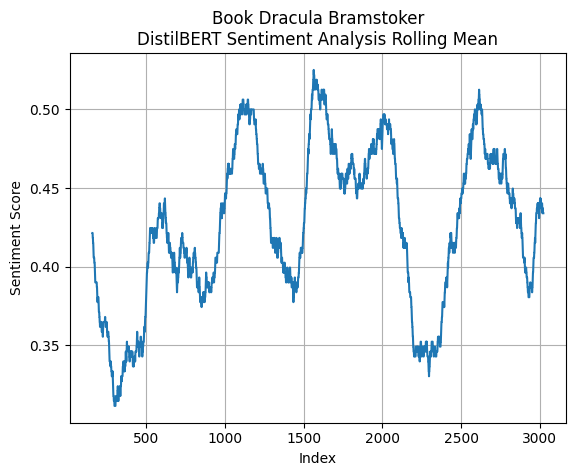

In [61]:
win_per = 0.1
win_size = int(win_per * distilbert_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'distilbert' sentiment column
_ = distilbert_df['distilbert'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nDistilBERT Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_distilbert')

plt.show()

# Close the plot to free up memory
plt.close()


In [62]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(distilbert_df, '_distilbert_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_dracula_bramstoker_distilbert_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_dracula_bramstoker_distilbert_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [63]:
# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [64]:
# Tokenize texts and create prediction data set

# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [65]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [66]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [67]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)
#        1m27s 02:42EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 1min 31s, sys: 287 ms, total: 1min 32s
Wall time: 1min 33s


In [68]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [69]:
line_no_ls = list(range(len(sentiment_ls)))

In [70]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','nlptown','label','score'])
nlptown_df.head()

,line_no,line,nlptown,label,score
0,0,dracula chapter i jonathan harker's journal (_...,0,1 star,0.299336
1,1,m.,0,1 star,0.286031
2,2,", on 1st may, arriving at vienna early next mo...",0,1 star,0.317647
3,3,"buda-pesth seems a wonderful place, from the g...",4,5 stars,0.467190
4,4,"i feared to go very far from the station, as w...",1,2 stars,0.420272


In [71]:
nlptown_df.shape

(3181, 5)

In [72]:
nlptown_df['label'].unique()

array(['1 star', '5 stars', '2 stars', '4 stars', '3 stars'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Dracula Bramstoker\nNLPTown Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_dracula_bramstoker_nlptown_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_dracula_bramstoker_nlptown_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

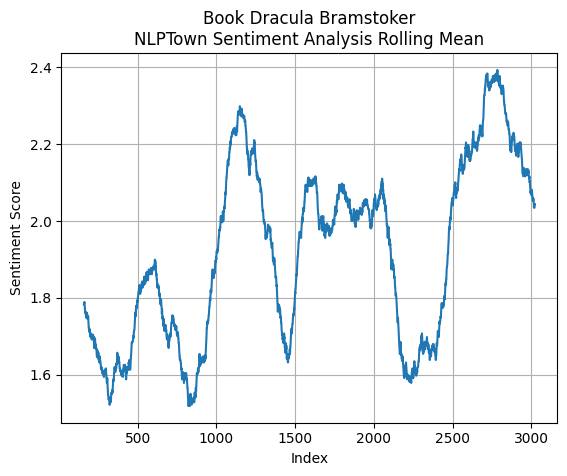

In [73]:
###CODE_7:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'nlptown' sentiment column
_ = nlptown_df['nlptown'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nNLPTown Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_nlptown')

plt.show()

# Close the plot to free up memory
plt.close()

In [74]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(nlptown_df, '_nlptown_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_dracula_bramstoker_nlptown_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_dracula_bramstoker_nlptown_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: RoBERTa Finetuned (en)

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [75]:
# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [76]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [77]:
# Tokenize texts and create prediction data set

line_ls = sentiment_df['line'].to_list()

tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [78]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 5min 5s, sys: 605 ms, total: 5min 5s
Wall time: 5min 7s


In [79]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [80]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [81]:
line_no_ls = list(range(len(sentiment_ls)))

In [82]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

,line_no,line,roberta15lg,label,score
0,0,dracula chapter i jonathan harker's journal (_...,0,NEGATIVE,0.987713
1,1,m.,0,NEGATIVE,0.562026
2,2,", on 1st may, arriving at vienna early next mo...",0,NEGATIVE,0.998378
3,3,"buda-pesth seems a wonderful place, from the g...",1,POSITIVE,0.994119
4,4,"i feared to go very far from the station, as w...",0,NEGATIVE,0.998216


In [83]:
roberta15lg_df['label'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Book Dracula Bramstoker\nRoBERTa Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_dracula_bramstoker_roberta15lg_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_dracula_bramstoker_roberta15lg_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

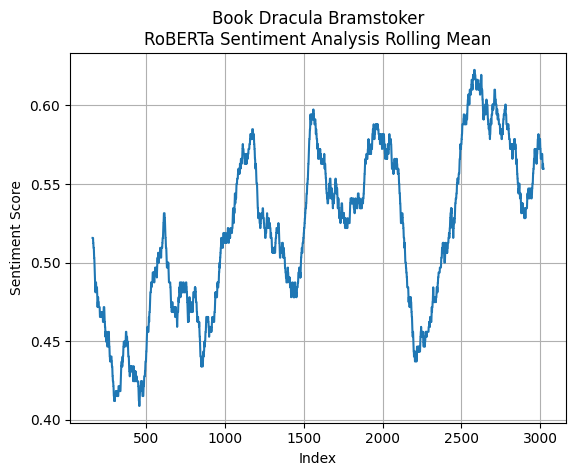

In [84]:
win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean of the 'roberta15lg' sentiment column
_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title(f"{BOOK_TITLE_AUTHOR_TITLE}\nRoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_roberta15lg')

plt.show()

# Close the plot to free up memory
plt.close()


In [85]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(roberta15lg_df, '_roberta15lg_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_dracula_bramstoker_roberta15lg_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_dracula_bramstoker_roberta15lg_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot

## Dialate SentimentR, Combine, and Plot Together

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [86]:
def clean_filenames_with_max_n(substr_del_template=' ({n})'):
    # Regex pattern to match the substring pattern " ({n})" where n is any integer
    pattern = re.compile(r' \((\d+)\)')

    # Dictionary to store filenames with their highest "n" value
    files_to_keep = {}

    # Iterate over all files in the current directory
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            # Extract the number and the root filename (without the " (n)" part and the extension)
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # Keep only the file with the highest "n" value for each base filename
            if base_filename not in files_to_keep or n_value > files_to_keep[base_filename][1]:
                files_to_keep[base_filename] = (filename, n_value)

    # Delete files that are not the one with the highest "n" value
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # If the current file is not the one to keep, delete it
            if filename != files_to_keep[base_filename][0]:
                print(f"Deleting file: {filename}")
                os.remove(filename)
            else:
                # Rename the kept file to remove the " (n)" part
                new_name = base_filename
                if filename != new_name:
                    print(f"Renaming {filename} to {new_name}")
                    os.rename(filename, new_name)

# Run the function
clean_filenames_with_max_n()


In [87]:
def make_csv_list(filename_root):
    # List of possible model names
    model_ls = ['vader', 'textblob', 'syuzhetr', 'sentimentr', 'distilbert', 'nlptown', 'roberta15lg']

    # Remove the file extension and extract the title_author part
    filename_without_ext = os.path.splitext(filename_root)[0]
    parts = filename_without_ext.split('_')
    title_author = '_'.join(parts[1:3])  # Get both parts of title_author (e.g., "dracula_bramstoker")

    # Initialize an empty list to hold the found CSV files
    csv_list = []

    # Debugging information
    print(f"Looking for files with title_author: {title_author}")

    # Iterate through each model name and construct the expected filename
    for model_name in model_ls:
        # Construct the filename based on the new pattern
        csv_filename = f'data_{title_author}_{model_name}_sentiment.csv'

        # Check if the file exists in the current directory
        if os.path.isfile(csv_filename):
            csv_list.append(csv_filename)
        else:
            print(f"File not found: {csv_filename}")

    return csv_list


In [88]:
!ls -altr

total 6372
drwxr-xr-x 4 root root   4096 Nov  8 14:19 .config
drwxr-xr-x 1 root root   4096 Nov  8 14:19 sample_data
drwxr-xr-x 1 root root   4096 Nov 12 17:08 ..
-rw-r--r-- 1 root root 866625 Nov 12 17:22 book_dracula_bramstoker.txt
-rw-r--r-- 1 root root 835498 Nov 12 17:25 book_dracula_bramstoker_segments.txt
-rw-r--r-- 1 root root  47315 Nov 12 17:27 plot_dracula_bramstoker_vader_sentiment.png
-rw-r--r-- 1 root root 878360 Nov 12 17:27 data_dracula_bramstoker_vader_sentiment.csv
-rw-r--r-- 1 root root  47812 Nov 12 17:27 plot_dracula_bramstoker_textblob_sentiment.png
-rw-r--r-- 1 root root 891193 Nov 12 17:27 data_dracula_bramstoker_textblob_sentiment.csv
drwxr-xr-x 2 root root   4096 Nov 12 17:28 results
-rw-r--r-- 1 root root  45126 Nov 12 17:29 plot_dracula_bramstoker_distilbert_sentiment.png
-rw-r--r-- 1 root root 925922 Nov 12 17:29 data_dracula_bramstoker_distilbert_sentiment.csv
-rw-r--r-- 1 root root  44225 Nov 12 17:30 plot_dracula_bramstoker_nlptown_sentiment.png
-rw-r--r

In [89]:
# sentiment_all_df.

In [90]:
# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)

# BOOK_FILENAME_AUTHOR_CLEAN = 'book_jane-eyre_cbronte'
# BOOK_FILENAME_AUTHOR_CLEAN = novel_name_str
BOOK_FILENAME_AUTHOR_CLEAN

'book_dracula_bramstoker'

In [91]:
# Example usage
csv_list = make_csv_list(BOOK_FILENAME_AUTHOR_CLEAN)
print(csv_list)

Looking for files with title_author: dracula_bramstoker
File not found: data_dracula_bramstoker_syuzhetr_sentiment.csv
File not found: data_dracula_bramstoker_sentimentr_sentiment.csv
['data_dracula_bramstoker_vader_sentiment.csv', 'data_dracula_bramstoker_textblob_sentiment.csv', 'data_dracula_bramstoker_distilbert_sentiment.csv', 'data_dracula_bramstoker_nlptown_sentiment.csv', 'data_dracula_bramstoker_roberta15lg_sentiment.csv']


In [92]:
models_sa_ls = make_csv_list(BOOK_FILENAME_AUTHOR_CLEAN)
for amodel in models_sa_ls:
  print(amodel)

Looking for files with title_author: dracula_bramstoker
File not found: data_dracula_bramstoker_syuzhetr_sentiment.csv
File not found: data_dracula_bramstoker_sentimentr_sentiment.csv
data_dracula_bramstoker_vader_sentiment.csv
data_dracula_bramstoker_textblob_sentiment.csv
data_dracula_bramstoker_distilbert_sentiment.csv
data_dracula_bramstoker_nlptown_sentiment.csv
data_dracula_bramstoker_roberta15lg_sentiment.csv


In [93]:
# models_sa_ls.remove('book_the-great-gatsby_fscottfitzgerald_sentimentr.csv')

In [94]:
for amodel in models_sa_ls:
  print(f"\n\n{amodel}")
  temp_df = pd.read_csv(amodel)
  print(temp_df.columns)



data_dracula_bramstoker_vader_sentiment.csv
Index(['line_no', 'line', 'vader'], dtype='object')


data_dracula_bramstoker_textblob_sentiment.csv
Index(['line_no', 'line', 'textblob'], dtype='object')


data_dracula_bramstoker_distilbert_sentiment.csv
Index(['line_no', 'line', 'distilbert', 'label', 'score'], dtype='object')


data_dracula_bramstoker_nlptown_sentiment.csv
Index(['line_no', 'line', 'nlptown', 'label', 'score'], dtype='object')


data_dracula_bramstoker_roberta15lg_sentiment.csv
Index(['line_no', 'line', 'roberta15lg', 'label', 'score'], dtype='object')


In [95]:
len(models_sa_ls)

5

In [96]:
sentiment_all_df = pd.read_csv(models_sa_ls[0])  # Start with vader

for i, amodel in enumerate(models_sa_ls[1:]):
    model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
    print(f'Model #{i}: {model_name_str}')

    one_model_df = pd.read_csv(amodel)
    print(f' Cols: {one_model_df.columns.to_list()}')

    # Special handling for sentimentr which has different structure
    if 'sentimentr' in model_name_str:
        # Add line_no as index+1 since sentimentr is missing it
        one_model_df['line_no'] = range(1, len(one_model_df) + 1)

    # Remove unnecessary columns
    cols_to_drop = ['line', 'label', 'score']
    for col in cols_to_drop:
        if col in one_model_df.columns:
            one_model_df.drop(columns=[col], inplace=True)

    # Rename sentiment column if it exists
    if 'sentiment' in one_model_df.columns:
        one_model_df.rename(columns={'sentiment': model_name_str}, inplace=True)

    # Merge on line_no
    sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

Model #0: sentiment
 Cols: ['line_no', 'line', 'textblob']
Model #1: sentiment
 Cols: ['line_no', 'line', 'distilbert', 'label', 'score']
Model #2: sentiment
 Cols: ['line_no', 'line', 'nlptown', 'label', 'score']
Model #3: sentiment
 Cols: ['line_no', 'line', 'roberta15lg', 'label', 'score']


In [97]:
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3181 entries, 0 to 3180
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3181 non-null   int64  
 1   line         3181 non-null   object 
 2   vader        3181 non-null   float64
 3   textblob     3181 non-null   float64
 4   distilbert   3181 non-null   int64  
 5   nlptown      3181 non-null   int64  
 6   roberta15lg  3181 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 174.1+ KB


In [98]:
# prompt: for sentiment_all_df columns rename sentiment_x and sentiment_y to vader and textblob

sentiment_all_df.rename(columns={'sentiment_x': 'vader', 'sentiment_y': 'textblob'}, inplace=True)
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3181 entries, 0 to 3180
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   line_no      3181 non-null   int64  
 1   line         3181 non-null   object 
 2   vader        3181 non-null   float64
 3   textblob     3181 non-null   float64
 4   distilbert   3181 non-null   int64  
 5   nlptown      3181 non-null   int64  
 6   roberta15lg  3181 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 174.1+ KB


In [99]:
%whos str

Variable                     Type    Data/Info
----------------------------------------------
BOOK_FILENAME_AUTHOR_CLEAN   str     book_dracula_bramstoker
BOOK_TITLE_AUTHOR_CLEAN      str     book_dracula_bramstoker
BOOK_TITLE_AUTHOR_TITLE      str     Book Dracula Bramstoker
DATA_FILENAME_AUTHOR_CLEAN   str     data_dracula_bramstoker
PLOT_FILENAME_AUTHOR_CLEAN   str     plot_dracula_bramstoker
TEXT_ENCODING                str     utf-8
amodel                       str     data_dracula_bramstoker_roberta15lg_sentiment.csv
col                          str     score
fn                           str     book_dracula_bramstoker.txt
model_name                   str     siebert/sentiment-roberta-large-english
model_name_str               str     sentiment
novel_clean_str              str     dracula chapter i jonatha<...>r sake." jonathan harker.
novel_name_str               str     book_dracula_bramstoker.txt
\n<...>                         
novel_trim_str               str     dracula cha

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'book_dracula_bramstoker\n SMA of Z-score Normalized Sentiment Scores')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: plot_dracula_bramstoker_all_sentiment.png

STEP 2. Downloading permanent copy of the PNG file: plot_dracula_bramstoker_all_sentiment.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

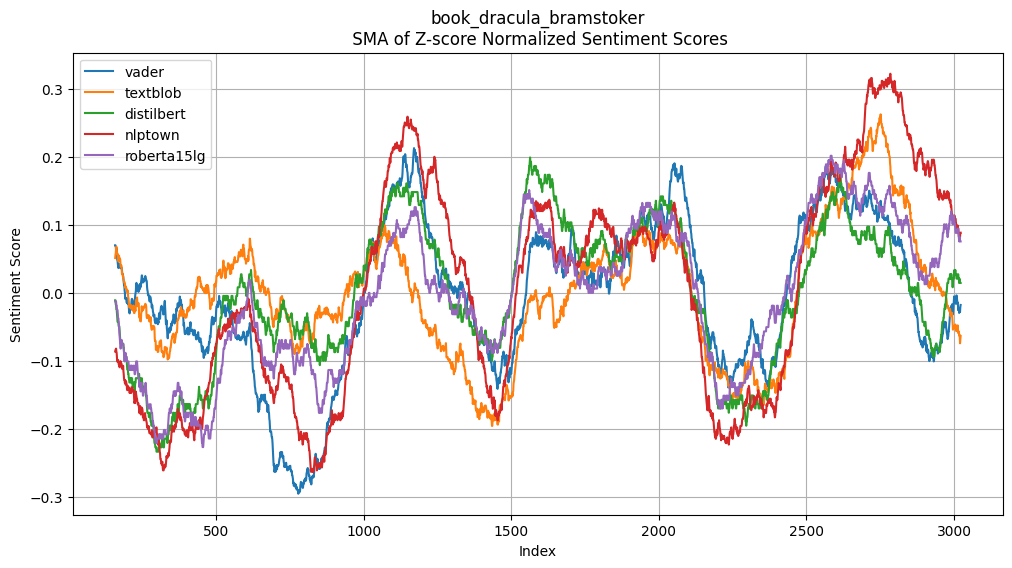

In [100]:
# prompt: on the same plot, first z-score normalize and then plot the sma (10% window) of vader, textblob, distilbert, nlptown, roberta15lg together

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming sentiment_all_df is your DataFrame containing sentiment scores for different models
# and it has columns 'vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg'

# Z-score normalize the sentiment scores
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
  sentiment_all_df[col] = zscore(sentiment_all_df[col])

# Calculate the SMA (Simple Moving Average) with a 10% window for each model
win_per = 0.1
win_size = int(win_per * sentiment_all_df.shape[0])
for col in ['vader', 'textblob', 'distilbert', 'nlptown', 'roberta15lg']:
  sentiment_all_df[f'{col}_sma'] = sentiment_all_df[col].rolling(win_size, center=True).mean()

# Plot the SMA of each model on the same plot
plt.figure(figsize=(12, 6))
for col in ['vader_sma', 'textblob_sma', 'distilbert_sma', 'nlptown_sma', 'roberta15lg_sma']:
  plt.plot(sentiment_all_df[col], label=col.replace('_sma', ''))

plt.title(f'{BOOK_TITLE_AUTHOR_CLEAN}\n SMA of Z-score Normalized Sentiment Scores')
plt.xlabel('Index')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)

# Save the plot to a PNG file with the updated function
save_plot2png('_sentiment.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_all')


plt.show()

In [101]:
# Save Model Sentiment Time Series to CSV with the updated function
save_df2csv_and_download(roberta15lg_df, '_all_sentiment.csv', nodate=True, base_filename=DATA_FILENAME_AUTHOR_CLEAN)


STEP 1. Saving DataFrame to temporary VM CSV file: data_dracula_bramstoker_all_sentiment.csv

STEP 2. Downloading permanent copy of the CSV file: data_dracula_bramstoker_all_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Crux Detection and Extraction

## Smooth Plots and Add Crux Points

In [102]:
def get_sentiment_mean(df):
    """Same as before"""
    sentiment_cols = [col for col in df.columns
                     if col not in ['line', 'line_no']]
    return df[sentiment_cols].mean(axis=1).tolist()


def detect_peaks_valleys(smoothed_series, peak_algo='find_peaks', peak_algo_params=None):
    """
    Detect peaks and valleys using specified algorithm.

    Args:
        smoothed_series (list): Smoothed and normalized time series
        peak_algo (str): Peak detection algorithm ('find_peaks', 'relmax', 'threshold')
        peak_algo_params (dict): Parameters for the chosen algorithm

    Returns:
        dict: Dictionary with 'peaks' and 'valleys' indices
    """
    series = np.array(smoothed_series)

    # Default parameters for each algorithm
    default_params = {
        'find_peaks': {
            'distance': 20,
            'prominence': 0.1
        },
        'relmax': {
            'order': 10
        },
        'threshold': {
            'threshold': 0.5,
            'min_dist': 20
        }
    }

    params = peak_algo_params if peak_algo_params is not None else default_params[peak_algo]

    if peak_algo == 'find_peaks':
        peaks, _ = find_peaks(series,
                            distance=params['distance'],
                            prominence=params['prominence'])
        valleys, _ = find_peaks(-series,
                              distance=params['distance'],
                              prominence=params['prominence'])

    elif peak_algo == 'relmax':
        peaks = argrelextrema(series, np.greater,
                            order=params['order'])[0]
        valleys = argrelextrema(series, np.less,
                              order=params['order'])[0]

    elif peak_algo == 'threshold':
        peaks = []
        valleys = []
        min_dist = params['min_dist']
        threshold = params['threshold']

        for i in range(1, len(series)-1):
            if peaks and i - peaks[-1] < min_dist:
                continue
            if valleys and i - valleys[-1] < min_dist:
                continue

            if (series[i] > series[i-1] + threshold and
                series[i] > series[i+1] + threshold):
                peaks.append(i)
            elif (series[i] < series[i-1] - threshold and
                  series[i] < series[i+1] - threshold):
                valleys.append(i)

    else:
        raise ValueError(f"Peak detection algorithm '{peak_algo}' not implemented. "
                        "Use 'find_peaks', 'relmax', or 'threshold'.")

    return {
        'peaks': peaks.tolist() if isinstance(peaks, np.ndarray) else peaks,
        'valleys': valleys.tolist() if isinstance(valleys, np.ndarray) else valleys
    }

def plot_cruxes(book_name, sentiment_mean_ls, sentiment_mean_smooth_ls,
                peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))

    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks with green dashed lines
    y_min, y_max = plt.ylim()
    text_y = y_max + 0.05 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}',
                rotation=90, va='bottom', ha='center')

    # Plot valleys with red dashed lines
    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}',
                rotation=90, va='bottom', ha='center')

    # Customize plot
    plt.title(f'Sentiment Analysis: {book_name}\nPeak Detection: {peak_algo}')
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')

    if SIMPLE:
        plt.legend(['Normalized Sentiment',
                   'Peak Lines', 'Valley Lines'])
    else:
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save plot
    plt.savefig(f'{book_name}_sentiment_plot_{peak_algo}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    return crux_points_dt  # Return detected points for further analysis

def smooth_ts(time_series, method='sma', smooth_param='0.1'):
    """Same as before"""
    series = np.array(time_series)

    if method == 'sma':
        window = max(3, int(float(smooth_param) * len(series)))
        if window % 2 == 0:
            window += 1
        pad_size = window // 2
        padded_series = np.pad(series, (pad_size, pad_size), mode='edge')
        smoothed = np.convolve(padded_series, np.ones(window)/window, mode='valid')

    elif method == 'lowess':
        x = np.arange(len(series))
        smoothed = lowess(
            series,
            x,
            frac=float(smooth_param),
            return_sorted=False
        )
    else:
        raise ValueError(f"Smoothing method '{method}' not implemented. Use 'sma' or 'lowess'.")

    smoothed_min = np.min(smoothed)
    smoothed_max = np.max(smoothed)
    smoothed_normalized = 2 * (smoothed - smoothed_min) / (smoothed_max - smoothed_min) - 1

    return smoothed_normalized.tolist()

In [103]:
def plot_cruxes(model_name, plot_title, sentiment_mean_ls, sentiment_mean_smooth_ls,
                smooth_algo, peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))
    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks and valleys
    y_min, y_max = plt.ylim()
    text_y = y_min + 0.9 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}', rotation=90, va='center', ha='center')

    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}', rotation=90, va='center', ha='center')

    # Customize plot
    # plt.title(f'{BOOK_TITLE_AUTHOR_CLEAN}\nPeak Detection: {peak_algo}')
    plt.title(plot_title)
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save plot before showing it
    plot_filename = f'{PLOT_FILENAME_AUTHOR_CLEAN}_{model_name}_{smooth_algo}_cruxes_{peak_algo}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    # Save the plot to a PNG file with the updated function
    # save_plot2png('_cruxes.png', nodate=True, base_filename=f'{PLOT_FILENAME_AUTHOR_CLEAN}_all')

    # Display the plot
    plt.show()

    # Close the plot to free up memory
    plt.close()

    # Return detected points for further analysis and the filename
    return crux_points_dt, plot_filename


## Choose Specific Model SentimentArc or Mean of All

In [104]:
# 1. Calculate mean sentiment across all columns

MODEL_INDEX = -1 # set to -1 to use mean of all models

model_ls = ['vader','textblob','distilbert','nlptown','roberta15lg']
if MODEL_INDEX > -1:
  model_name = model_ls[MODEL_INDEX]
  sentiment_mean_ls = sentiment_all_df[model_name].tolist()
else:
  model_name = 'mean'
  sentiment_mean_ls = get_sentiment_mean(sentiment_all_df)


In [105]:
# FUTURE: Use Colab widgets
# print(model_dropdown.value)

In [106]:
print(f"Model: {model_name}")

Model: mean


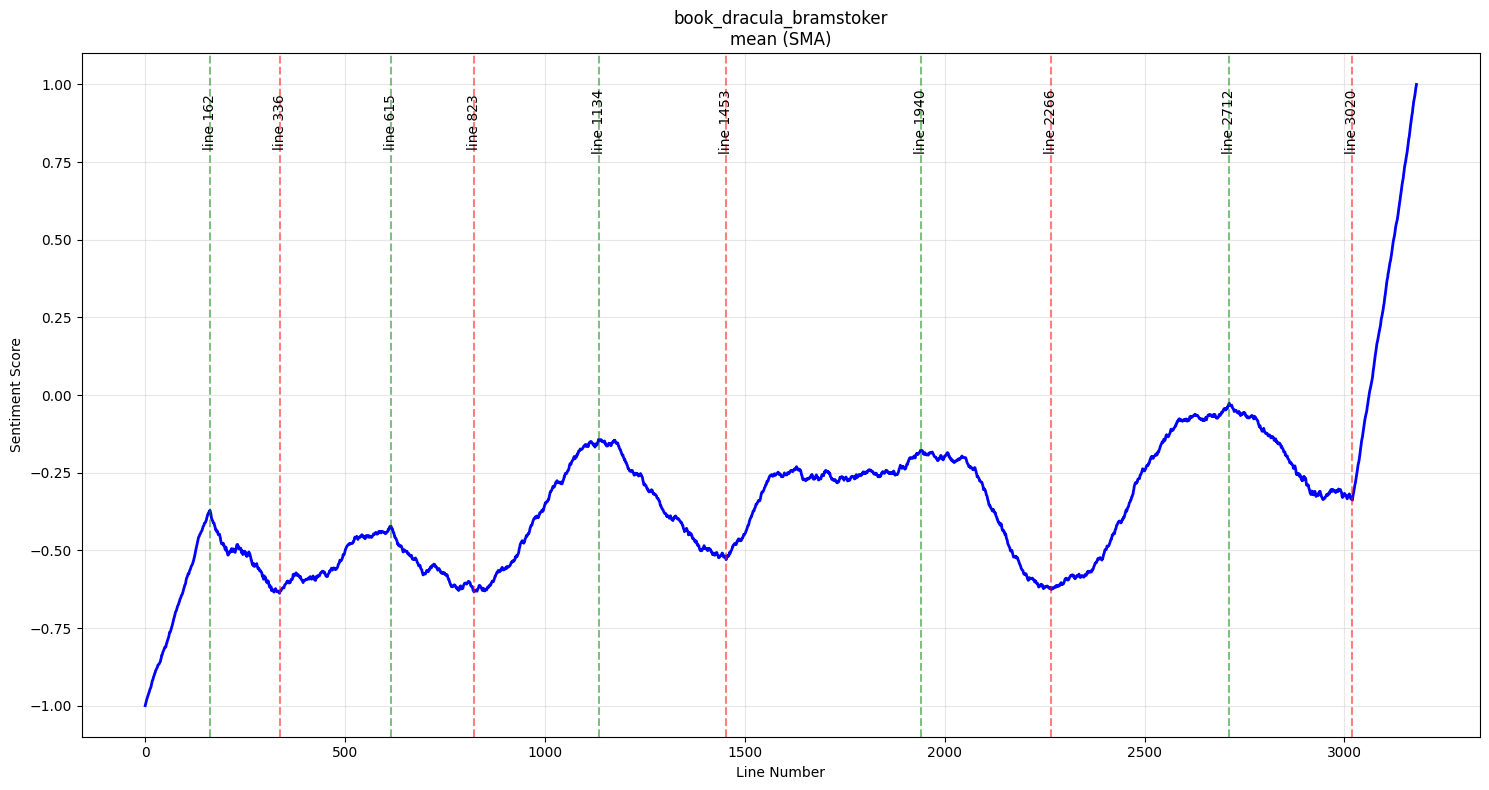

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

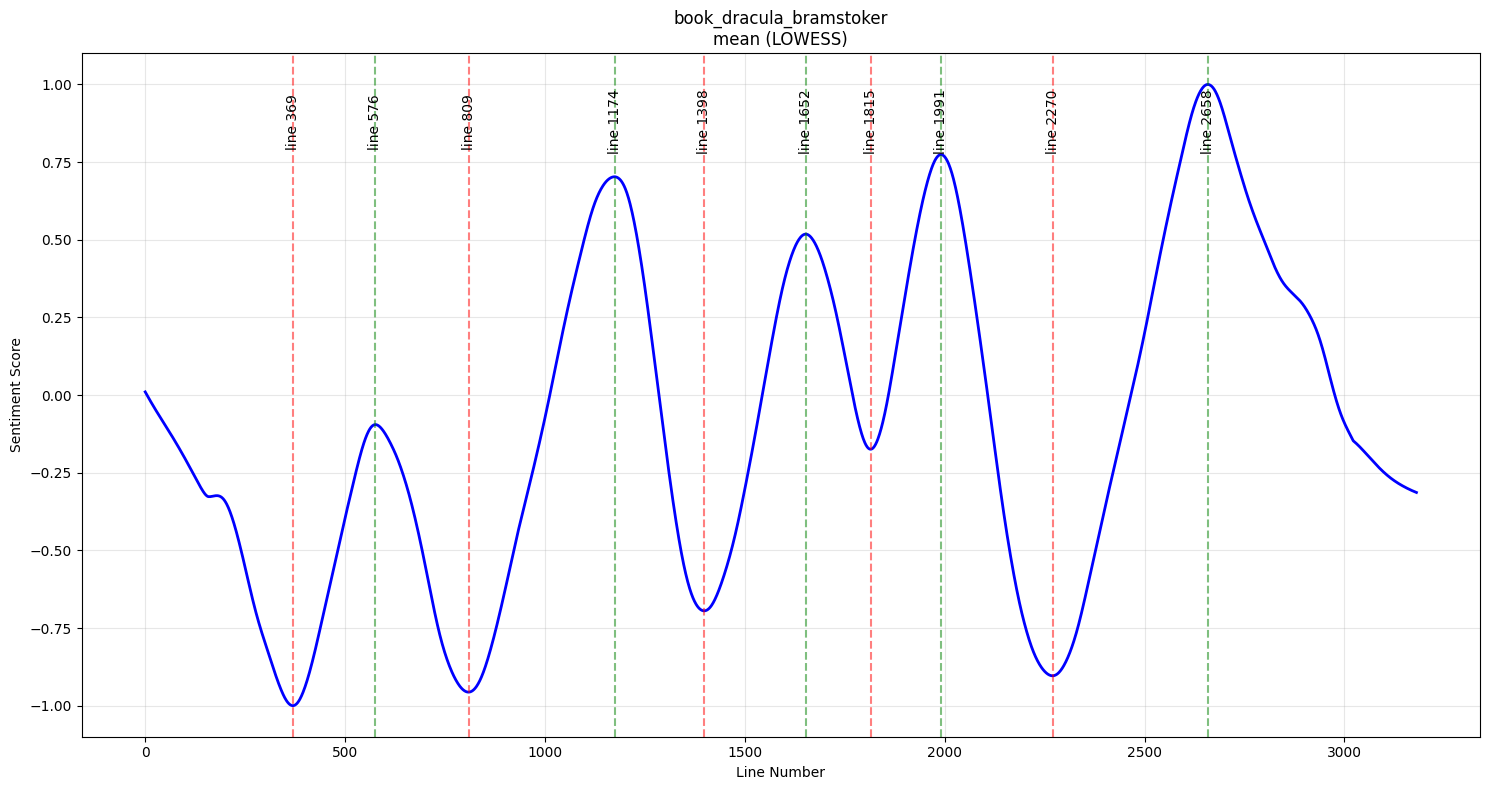

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
# 2. Create both SMA and LOWESS smoothed versions
smoothed_sma = smooth_ts(sentiment_mean_ls, method='sma', smooth_param=0.1)
smoothed_lowess = smooth_ts(sentiment_mean_ls, method='lowess', smooth_param=0.1)

# 3. Set up peak detection parameters
peak_params = {
    'distance': 30,
    'prominence': 0.15
}

# 4a. Generate and save SMA plot
crux_points_sma, sma_plot_filename = plot_cruxes(
    model_name,
    BOOK_TITLE_AUTHOR_CLEAN + "\n" + model_name + " (SMA)",
    sentiment_mean_ls,
    smoothed_sma,
    smooth_algo='sma',
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

# Download SMA plot
files.download(sma_plot_filename)

# 4b. Generate and save LOWESS plot
crux_points_lowess, lowess_plot_filename = plot_cruxes(
    model_name,
    BOOK_TITLE_AUTHOR_CLEAN + "\n" + model_name + " (LOWESS)",
    sentiment_mean_ls,
    smoothed_lowess,
    smooth_algo='lowess',
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)

# Download LOWESS plot
files.download(lowess_plot_filename)


## Generate Crux Reports

In [108]:
# SET Default length of context Window around center Crux Sentence (# sentences incl. center crux sentence)

CONTEXT_WIN_DEFAULT = 11

In [109]:
def get_crux_text(df, smoothed_series, peak_algo='find_peaks', peak_algo_params=None, context_win=CONTEXT_WIN_DEFAULT):
    """
    Extract text surrounding crux points with sentiment values. Center line is uppercased.

    Args:
        df (pd.DataFrame): Input dataframe
        smoothed_series (list): Smoothed time series
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
        context_win (int): Window size for text extraction (odd number)

    Returns:
        tuple: Dictionaries for peaks and valleys text with sentiment
    """
    # Use detect_peaks_valleys instead of get_crux_points
    crux_points_dt = detect_peaks_valleys(smoothed_series, peak_algo, peak_algo_params)

    half_win = context_win // 2
    peaks_dict = {}
    valleys_dict = {}

    def extract_window_text(center_idx, sentiment_val):
        start_idx = max(0, center_idx - half_win)
        end_idx = min(len(df), center_idx + half_win + 1)

        text_lines = df['line'].iloc[start_idx:end_idx].tolist()
        center_relative_idx = center_idx - start_idx
        if 0 <= center_relative_idx < len(text_lines):
            text_lines[center_relative_idx] = text_lines[center_relative_idx].upper()

        return [sentiment_val, text_lines]

    for peak in crux_points_dt['peaks']:
        sentiment_val = smoothed_series[peak]
        peaks_dict[peak] = extract_window_text(peak, sentiment_val)

    for valley in crux_points_dt['valleys']:
        sentiment_val = smoothed_series[valley]
        valleys_dict[valley] = extract_window_text(valley, sentiment_val)

    return peaks_dict, valleys_dict

In [110]:
def make_crux_report(book_name, smoothed_series, df, peak_algo='find_peaks', peak_algo_params=None):
    """
    Generate and save formatted report of crux points analysis.
    Uses fixed window size of 21 lines and highlights crux point lines.

    Args:
        book_name (str): Name of the book being analyzed
        smoothed_series (list): Smoothed time series
        df (pd.DataFrame): Input dataframe with text
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
    """
    crux_peaks_text_dt, crux_valleys_text_dt = get_crux_text(
        df, smoothed_series, peak_algo, peak_algo_params, context_win=21
    )

    # Prepare a sorted list of all crux points with labels
    crux_summary = []
    for line_no, (sentiment, text) in crux_peaks_text_dt.items():
        crux_summary.append((line_no, sentiment, "Peak"))
    for line_no, (sentiment, text) in crux_valleys_text_dt.items():
        crux_summary.append((line_no, sentiment, "Valley"))
    crux_summary.sort(key=lambda x: x[0])  # Sort by line number

    report = []

    # Add summary of all crux points at the top
    report.append(f"Sentiment Analysis Crux Points Report for: {book_name}")
    report.append(f"Peak Detection Algorithm: {peak_algo}")
    report.append("Window Size: 21 lines (10 before, CRUX LINE, 10 after)")
    report.append("=" * 80)
    report.append("SUMMARY OF CRUX POINTS")
    report.append("-" * 40)
    for line_no, sentiment, label in crux_summary:
        report.append(f"{label} at line {line_no} (Sentiment: {sentiment:.3f})")
    report.append("=" * 80 + "\n")

    # Add details for Peaks
    report.append("EMOTIONAL PEAKS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_peaks_text_dt.items()):
        report.append(f"\nPeak at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    # Add details for Valleys
    report.append("\nEMOTIONAL VALLEYS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_valleys_text_dt.items()):
        report.append(f"\nValley at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [textwrap.fill(line, width=70) for line in text]
        report.extend(wrapped_text)
        report.append("-" * 40)

    # Join all report lines into a single string and save to a file
    report_text = "\n".join(report)
    report_filename = f"{book_name}_crux_report_{peak_algo}.txt"
    with open(report_filename, "w", encoding="utf-8") as f:
        f.write(report_text)

    print(report_text)
    return report_filename  # Return the filename for use in downloading


In [111]:
# 5. Generate reports for both smoothing methods
from google.colab import files

# 5a. SMA report
sma_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR_CLEAN + " " + model_name + "_sma",
    smoothed_sma,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download SMA report
files.download(sma_report_filename)

# 5b. LOWESS report
lowess_report_filename = make_crux_report(
    BOOK_FILENAME_AUTHOR_CLEAN + " " + model_name + "_lowess",
    smoothed_lowess,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download LOWESS report
files.download(lowess_report_filename)


Sentiment Analysis Crux Points Report for: book_dracula_bramstoker mean_sma
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)
SUMMARY OF CRUX POINTS
----------------------------------------
Peak at line 162 (Sentiment: -0.371)
Valley at line 336 (Sentiment: -0.638)
Peak at line 615 (Sentiment: -0.422)
Valley at line 823 (Sentiment: -0.633)
Peak at line 1134 (Sentiment: -0.143)
Valley at line 1453 (Sentiment: -0.530)
Peak at line 1940 (Sentiment: -0.178)
Valley at line 2266 (Sentiment: -0.626)
Peak at line 2712 (Sentiment: -0.026)
Valley at line 3020 (Sentiment: -0.338)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 162 (Sentiment: -0.371)
----------------------------------------
i long to go through the crowded streets of your mighty london, to be
in the midst of the whirl and rush of humanity, to share its life, its
change, its death, and all that makes it what it is. but alas! as yet
i only know your tongue through bo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sentiment Analysis Crux Points Report for: book_dracula_bramstoker mean_lowess
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)
SUMMARY OF CRUX POINTS
----------------------------------------
Valley at line 369 (Sentiment: -1.000)
Peak at line 576 (Sentiment: -0.095)
Valley at line 809 (Sentiment: -0.956)
Peak at line 1174 (Sentiment: 0.703)
Valley at line 1398 (Sentiment: -0.695)
Peak at line 1652 (Sentiment: 0.518)
Valley at line 1815 (Sentiment: -0.174)
Peak at line 1991 (Sentiment: 0.774)
Valley at line 2270 (Sentiment: -0.904)
Peak at line 2658 (Sentiment: 1.000)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 576 (Sentiment: -0.095)
----------------------------------------
this gave me an idea, or the rudiment of one.
i must watch how he gets rid of his spiders.
he has evidently some deep problem in his mind, for he keeps a little
note-book in which he is always jotting down something.
whole pages of it are filled

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>